<a href="https://colab.research.google.com/github/rishi-latchmepersad/tensorflow_tutorials/blob/main/getting_started_with_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Core Deep Learning Model Families

This is a quick overview of the different types of NN layers available today.
---

## 1) MLP, Feed-Forward networks
What: Stacked fully connected layers on vector inputs.

Intuition: Each neuron looks at all features at once, learns a weighted sum, then applies a nonlinearity. Deeper stacks learn more abstract combinations.

How it works: Every layer takes the previous layer’s numbers, multiplies by a learned weight matrix, adds a bias, then applies something like ReLU. Stacking layers means you can learn complex input to output mappings.

When to use: Tabular data, small classifiers, quick baselines.

Limits: No built-in notion of space or time. Flattening images or long sequences throws away structure and inflates parameter count.

TinyML notes: Good as a small classifier head after a compact encoder. Avoid large Flattened inputs.

Typical Keras: Dense → ReLU → Dropout → Dense.

---

## 2) Convolutional Neural Networks (CNNs)

### 2D CNNs for images
What: Sliding filters that scan across height and width, detecting local patterns like edges, corners, textures, then shapes in deeper layers.

Intuition: A small kernel, for example 3 by 3, moves across the image. The same weights are reused everywhere. That reuse makes the model data efficient and sensitive to local structure. Pooling or stride adds some shift invariance.

How it works: For each filter, take a small patch under the kernel, multiply by kernel weights, sum, and produce one number. Do this at every location to build a feature map. Multiple filters produce multiple channels. Deeper layers stack more filters, which increases the effective field of view.

Key vocabulary:
- Stride: how far the window moves each step.
- Padding: “same” keeps size, “valid” shrinks it.
- Pooling: downsamples by taking max or average inside a window.
- Global Average Pooling (GAP): average each channel over the whole spatial grid to get a short vector.

When to use: Any image task, including tiny images like MNIST or small gauge crops.

TinyML notes: Prefer DepthwiseConv2D and GAP for parameter and compute savings. Keep activations simple, for example ReLU or ReLU6.

Typical Keras: [Conv2D → ReLU] one to three times, then Pool, repeat once or twice, then GAP, then Dense softmax.

### 1D CNNs for sequences
What: Sliding filters along time that capture short patterns and trends in sensor streams or audio features.

Intuition: Same idea as 2D but along one axis. Causal padding ensures the model does not peek into the future. Dilations let filters skip steps to see further back without adding many parameters.

How it works: A kernel of width k looks at the last k steps and produces one output step. Stacking layers increases temporal coverage. Adding dilation means the kernel samples every second, fourth, eighth step, and so on, which expands reach quickly.

When to use: Forecasting, sequence classification for sensors, simple audio tasks.

TinyML notes: Often faster and lighter than RNNs for similar accuracy. Uses standard conv ops with strong TFLite Micro support.

Typical Keras: Conv1D with padding set to causal → ReLU → optional dilated Conv1D → GAP → Dense.

### Depthwise-separable CNNs
What: A factorized convolution for efficiency.

Intuition: First, a depthwise step applies one small spatial filter per channel. Second, a pointwise 1 by 1 conv mixes channels. This separates spatial and channel mixing.

Why it helps: Regular conv does spatial work and channel mixing in one heavy step. Splitting the steps reduces parameters and multiply-adds significantly.

TinyML notes: Often the best accuracy per kilobyte for small vision models.

Typical Keras block: DepthwiseConv2D → Conv2D with kernel size 1 → ReLU → Pool.

---

## 3) Residual CNNs and inverted residuals
What: Convolutional blocks with skip connections or MobileNet-style bottlenecks.

Intuition: Learn a residual function and add it back to the input. The identity path keeps gradients healthy, so you can stack more layers without training issues.

How it works: A small stack of convs processes the input to produce a residual. Add the residual to the original input, then apply an activation. Inverted residuals expand channels with a 1 by 1 conv, apply a depthwise conv, then project back down with another 1 by 1 conv, often with a linear activation at the end.

When to use: When you want to go a bit deeper without losing stability. Very common even in compact networks.

TinyML notes: Adds a cheap Add op and keeps two tensors alive until the merge. Usually worth it.

---

## 4) Temporal Convolutional Networks (TCN)
What: Sequence models built from causal, dilated Conv1D blocks with residual connections.

Intuition: By doubling the dilation each layer, a few layers can see a long history. You keep full parallelism over time and avoid recurrent loops.

How it works: Each block uses Conv1D with a chosen dilation rate, often 1, 2, 4, 8, and so on, plus a skip connection. The effective temporal coverage grows quickly with depth.

When to use: Forecasting and sequence modeling where you need long context but want fast, stable training.

TinyML notes: Uses only conv and add. Very deployment friendly.

---

## 5) RNNs, LSTM, GRU
What: Recurrent models with a learned hidden state that carries information through time.

Intuition: At each time step, the model updates a hidden state using the previous state and the current input. LSTM and GRU add gates that decide what to keep, what to forget, and what to write, which helps with long-term dependencies.

How it works: A simple RNN updates state with a nonlinearity. LSTM and GRU add learned gates that control the flow of information. This reduces vanishing or exploding gradients compared with a plain RNN.

When to use: When true long memory is essential and Conv1D or TCN underperform.

Limits: Sequential time steps reduce parallelism. Often heavier than Conv1D for similar context.

TinyML notes: TFLite supports LSTM and GRU. TFLite Micro support is improving, but Conv1D or TCN is usually easier.

---

## 6) Transformers
What: Models that use self-attention to mix information across all positions in a sequence or across image patches.

Intuition: Every position can look at every other position and decide how much to pay attention to it. This gives global context quickly.

How it works: Inputs are projected to queries, keys, and values. Attention weights are computed by comparing queries to keys, then applied to values. Multi-head attention runs several of these in parallel. Since attention mixes positions freely, the model adds positional information separately.

When to use: Language, Vision Transformers, multimodal tasks. Use only if you really need global mixing or plan to distill back to a small CNN.

TinyML notes: Memory heavy. Not a first choice for microcontrollers.

---

## 7) Autoencoders and Variational Autoencoders
What: Learn a compact latent code that can reconstruct the input.

Intuition: The encoder compresses, the decoder rebuilds. The bottleneck forces the model to keep only the most important information. VAEs treat the latent as a distribution, which regularizes and enables sampling.

How it works: Autoencoders minimize a reconstruction loss between input and output. VAEs add a regularization term that keeps the latent distribution close to a simple prior.

When to use: Denoising, anomaly detection, learned compression.

TinyML notes: Small autoencoders can run on MCUs. Keep the decoder shallow and the latent small.

---

## 8) GANs
What: A generator produces samples and a discriminator tries to tell real from fake. They train together.

Intuition: The generator learns to fool the discriminator. The discriminator learns to detect fakes. Each improves the other.

When to use: Data synthesis, style transfer, augmentation.

Limits: Training is delicate and sensitive to hyperparameters.

TinyML notes: Train off device. Generator inference can still be heavy.

---

## 9) Diffusion models
What: Generative models that learn to denoise step by step.

Intuition: Start from noise and repeatedly denoise to produce a sample. The model learns the denoising steps during training.

When to use: High fidelity image or audio generation. Not for MCUs.

---

## 10) Graph Neural Networks
What: Neural nets for graph-structured data such as molecules and road networks.

Intuition: Each node gathers messages from neighbors, mixes them with its own state, and updates. After several rounds, each node encodes information from a larger neighborhood.

How it works: A message function produces neighbor messages, an aggregation function combines them, then a small MLP updates the node state. Repeat across layers.

When to use: When relationships are best represented as a graph.

TinyML notes: Irregular structures and custom ops make deployment hard today.


In [1]:
# install/upgrade the packages we need
!pip install --upgrade keras
!pip install --upgrade keras-cv
!pip install --upgrade keras-hub
!pip install --upgrade keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 21.2 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.10.0
    Uninstalling keras-3.10.0:
      Successfully uninstalled keras-3.10.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 947.9/947.9 kB 22.2 MB/s eta 0:00:00
  Attempting uninstall: keras-hub
    Found existing installation: keras-hub 0.21.1
    Uninstalling keras-hub-0.21.1:
      Successfully uninstalled keras-hub-0.21.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
keras-nlp 0.21.1 requires keras-hub==0.21.1, but you have keras-hub 0.22.2 which is incompatible.


In [11]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
import numpy as np
from keras import layers as L
keras.utils.set_random_seed(42) # set seed to ensure reproducibility
from keras import ops
import matplotlib.pyplot as plt
from typing import List, Tuple, Optional, Callable, Dict, Iterable, Union
import time
import tensorflow as tf
import math

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


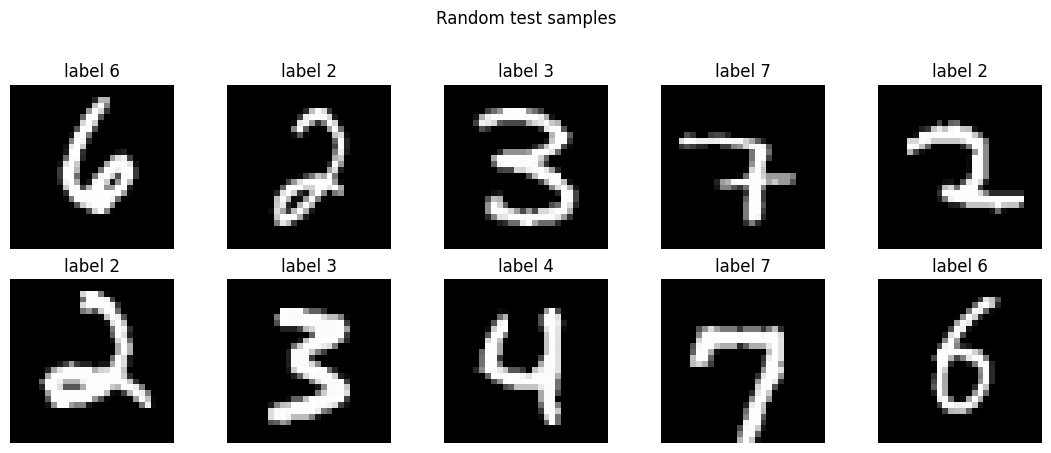

In [3]:
# the mnist dataset is a large dataset (60000 images) of handwritten digits from 0-9, commonly used to evaluate computer vision tasks
# we first load the data and split it between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# let's plot 10 random images from our test dataset, to see what we're trying to predict

# first we sample 10 random indices from the test set
indices = np.random.choice(len(x_test), size=10, replace=False)

# then we grab the images and labels for those indices.
imgs   = x_test[indices]      # shape (10, H, W, C) or (10, H, W)
labels = y_test[indices]      # shape (10,)

# ensure images are 4D for prediction (N, H, W, C). If they’re (N, H, W) add the channel axis.
if imgs.ndim == 3:
    imgs = imgs[..., None]

# then plot a 2×5 grid
rows, cols = 2, 5
plt.figure(figsize=(cols * 2.2, rows * 2.2))
for i, (img, y_true) in enumerate(zip(imgs, labels)):
    plt.subplot(rows, cols, i + 1)

    # Display: grayscale if single channel, RGB otherwise
    if img.shape[-1] == 1:
        # Pick display range based on dtype for nicer contrast
        vmin, vmax = (0, 255) if img.dtype == np.uint8 else (0, 1)
        plt.imshow(img.squeeze(), cmap="gray", vmin=vmin, vmax=vmax)
    else:
        plt.imshow(img)

    title = f"label {int(y_true)}"
    plt.title(title)
    plt.axis("off")

plt.suptitle("Random test samples", y=1.02)
plt.tight_layout()
plt.show()

In [4]:
# now let's process our dataset to prepare for training our model
# normalize the images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# the mnist dataset provides a set of 28x28 greyscale images, but it doesn't explicitly set the number of channels to be 1 (greyscale)
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
# so we add the extra dimension to the end for use in the later convolution layers
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print("y_train shape:", x_test.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

x_train shape: (60000, 28, 28)
x_test shape: (10000, 28, 28)
x_train shape: (60000, 28, 28, 1)
y_train shape: (10000, 28, 28, 1)
60000 train samples
10000 test samples


In [5]:
# now we build our model to predict the digit using the keras functional API
def build_functional_model(input_shape, num_classes):
    """
    Build a small VGG-style CNN using the keras functional API.
    input_shape: tuple (H, W, C), for MNIST (usually (28, 28, 1))
    num_classes: number of output classes for classification (usually 10 for MNIST)
    """
    inputs = keras.Input(shape=input_shape)         # Define the symbolic input tensor for the computation graph

    # First convolutional block: two 3×3 convs and a max pooling layer
    # Note: padding='valid' is the default and shrinks H and W by 2 each conv.
    # If we want to keep spatial size, set padding='same'.
    x = L.Conv2D(64, (3, 3), activation="relu")(inputs)   # Extract local features with 64 filters, add nonlinearity
    x = L.Conv2D(64, (3, 3), activation="relu")(x)        # Stack another 3×3 to expand receptive field with modest params
    x = L.MaxPooling2D((2, 2))(x)                         # Downsample by 2, reduce compute, gain some translation invariance

    # Second convolutional block: two more 3x3 convs
    # increase channel depth as resolution drops
    x = L.Conv2D(128, (3, 3), activation="relu")(x)       # Learn richer features at lower spatial resolution
    x = L.Conv2D(128, (3, 3), activation="relu")(x)       # Another 3×3 for more expressive power without huge kernels

    # Finally, our classifier head: make features compact, regularize, then classify
    x = L.GlobalAveragePooling2D()(x)                     # Average each feature map over H and W, get a 128-D vector; avoids large Dense layers
    x = L.Dropout(0.5)(x)                                 # Randomly drop activations during training, reduce overfitting; inactive at inference

    outputs = L.Dense(num_classes, activation="softmax")(x)  # Map to class probabilities for single-label multiclass tasks

    return keras.Model(inputs=inputs,                      # Assemble inputs and outputs into a Model object
                       outputs=outputs,
                       name="mnist_predict_digits")


In [6]:
# call the function to build the model. we use 10 classes since we have digits 0-9, and use the first training element to set the input shape
model:keras.Model = build_functional_model(input_shape=x_train.shape[1:], num_classes=10)
# compile the model to set the rules for fitting and evaluating the model.
# adam is usually a good default optimizer (it uses SGD)
# we use sparse categorical crossentropy for the loss since we have multiple output classes which are integers (0-9)
# and we want to report on accuracy
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.summary()
## plot the model graph if we need it
# keras.utils.plot_model(model, "my_first_model_with_shape_info.png", show_shapes=True)

Model: "mnist_predict_digits"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 26, 26, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 10, 10, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 260,298 (1016.79 KB)

 Trainable params: 260,298 (1016.79 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# now we actually train our model using our test data
# first we define callbacks that make training safer and faster.
callbacks = [
    # EarlyStopping watches validation loss; if it stops improving for 'patience' epochs,
    # training halts early to prevent overfitting and to save time.
    # restore_best_weights=True puts the model back to the epoch with the lowest val_loss.
    keras.callbacks.EarlyStopping(
        monitor="val_loss",     # default; explicit for clarity
        patience=5,             # wait 5 epochs without improvement
        restore_best_weights=True
    ),

    # ReduceLROnPlateau lowers the learning rate when validation loss stalls.
    # This often lets the optimizer settle into a better minimum after the fast phase.
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,             # cut LR in half each time the plateau is detected
        patience=2,             # wait 2 stagnant epochs before reducing LR
        min_lr=1e-5             # do not shrink below this floor
    ),
]

# then we train/fit the model.
history = model.fit(
    x_train, y_train,
    validation_split=0.1,       # hold out 10% of training data for validation;
                                # callbacks look at this, not the test set, to avoid leakage
    epochs=20,                  # maximum number of passes; EarlyStopping may stop earlier
    batch_size=128,             # tradeoff between speed and generalization; 128 is a solid default
    callbacks=callbacks,               # attach the callbacks defined above
    verbose=2                   # concise logs per epoch; change to 1 or 0 if you prefer
)

# then evaluate once on the unseen test set.
# This gives an unbiased estimate of generalization, since we did not peek at it during training.
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)

# finally report results for our model in a compact way.
print(f"Test loss: {test_loss:.4f}  |  Test accuracy: {test_acc:.4f}")

Epoch 1/20
422/422 - 20s - 47ms/step - accuracy: 0.7507 - loss: 0.7329 - val_accuracy: 0.9593 - val_loss: 0.1547 - learning_rate: 1.0000e-03
Epoch 2/20
422/422 - 8s - 19ms/step - accuracy: 0.9396 - loss: 0.2016 - val_accuracy: 0.9802 - val_loss: 0.0766 - learning_rate: 1.0000e-03
Epoch 3/20
422/422 - 5s - 11ms/step - accuracy: 0.9591 - loss: 0.1373 - val_accuracy: 0.9847 - val_loss: 0.0568 - learning_rate: 1.0000e-03
Epoch 4/20
422/422 - 5s - 11ms/step - accuracy: 0.9663 - loss: 0.1149 - val_accuracy: 0.9857 - val_loss: 0.0505 - learning_rate: 1.0000e-03
Epoch 5/20
422/422 - 5s - 11ms/step - accuracy: 0.9725 - loss: 0.0965 - val_accuracy: 0.9888 - val_loss: 0.0396 - learning_rate: 1.0000e-03
Epoch 6/20
422/422 - 5s - 11ms/step - accuracy: 0.9762 - loss: 0.0807 - val_accuracy: 0.9897 - val_loss: 0.0371 - learning_rate: 1.0000e-03
Epoch 7/20
422/422 - 5s - 11ms/step - accuracy: 0.9776 - loss: 0.0741 - val_accuracy: 0.9907 - val_loss: 0.0341 - learning_rate: 1.0000e-03
Epoch 8/20
422/422 

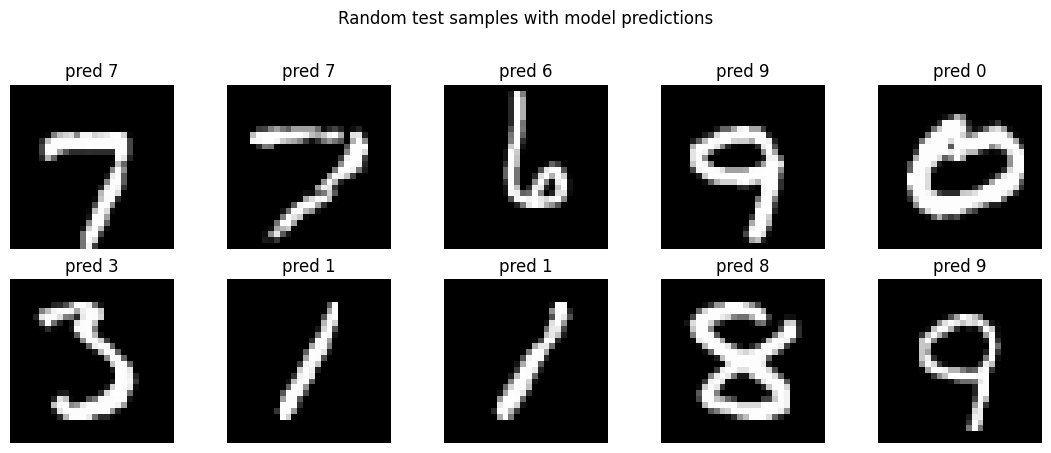

In [8]:
# plot 10 images from our test dataset to help us visualize how our model is performing

# first we sample 10 random indices from the test set
indices = np.random.choice(len(x_test), size=10, replace=False)

# then we grab the images and labels for those indices.
imgs   = x_test[indices]      # shape (10, H, W, C) or (10, H, W)
labels = y_test[indices]      # shape (10,)

# ensure images are 4D for prediction (N, H, W, C). If they’re (N, H, W) add the channel axis.
if imgs.ndim == 3:
    imgs = imgs[..., None]

# then run the model to get class probabilities, and take argmax → predicted class ID per image.
probs = model.predict(imgs, verbose=0)      # shape (10, num_classes)
preds = probs.argmax(axis=1)

# then plot a 2×5 grid, labeling each tile with the predicted class (and the true one if wrong).
rows, cols = 2, 5
plt.figure(figsize=(cols * 2.2, rows * 2.2))
for i, (img, y_true, y_pred) in enumerate(zip(imgs, labels, preds)):
    plt.subplot(rows, cols, i + 1)

    # Display: grayscale if single channel, RGB otherwise
    if img.shape[-1] == 1:
        # Pick display range based on dtype for nicer contrast
        vmin, vmax = (0, 255) if img.dtype == np.uint8 else (0, 1)
        plt.imshow(img.squeeze(), cmap="gray", vmin=vmin, vmax=vmax)
    else:
        plt.imshow(img)

    ok = int(y_true) == int(y_pred)
    title = f"pred {int(y_pred)}" if ok else f"pred {int(y_pred)} (true {int(y_true)})"
    plt.title(title)
    plt.axis("off")

plt.suptitle("Random test samples with model predictions", y=1.02)
plt.tight_layout()
plt.show()


In [14]:
# now let's shrink this model using tflite

# first set up some useful helper functions

# -----------------------------------------------------------------------------
# Helpers: readable sizes, accuracy functions, and TFLite memory estimation
# -----------------------------------------------------------------------------

def bytes_to_readable(num_bytes: int) -> str:
    """
    Convert a byte count into a human-friendly string.
    Why: quick comparison of model footprints without mental math.
    """
    if num_bytes < 1024:
        return f"{num_bytes} B"
    kb = num_bytes / 1024.0
    if kb < 1024:
        return f"{kb:.1f} KB"
    mb = kb / 1024.0
    return f"{mb:.2f} MB"

def compute_keras_accuracy(
    keras_model: keras.Model,
    inputs: np.ndarray,
    labels: np.ndarray,
    batch_size: int = 512
) -> float:
    """
    Accuracy from the full Keras model via predict + argmax.
    Why: matches the TFLite evaluation style for a fair comparison.
    """
    predicted_class_ids: np.ndarray = keras_model.predict(
        inputs, batch_size=batch_size, verbose=0
    ).argmax(axis=1)
    return float((predicted_class_ids == labels).mean())

def compute_tflite_accuracy(
    tflite_model: Union[str, bytes, bytearray],
    inputs: np.ndarray,
    labels: np.ndarray,
    number_of_examples: Optional[int] = None
) -> float:
    """
    Accuracy from a TFLite model (float or quantized).
    Auto-quantizes the input batch to uint8/int8 if needed based on model metadata.
    Why: compare deployment model accuracy to the original Keras model.
    """
    interpreter: tf.lite.Interpreter = (
        tf.lite.Interpreter(model_content=tflite_model)
        if isinstance(tflite_model, (bytes, bytearray))
        else tf.lite.Interpreter(model_path=tflite_model)
    )
    interpreter.allocate_tensors()

    input_details: Dict = interpreter.get_input_details()[0]
    output_details: Dict = interpreter.get_output_details()[0]

    input_dtype = input_details["dtype"]
    input_scale, input_zero_point = input_details["quantization"]

    total: int = len(inputs) if number_of_examples is None else min(number_of_examples, len(inputs))
    correct: int = 0

    for index in range(total):
        single_input: np.ndarray = inputs[index:index+1]  # keep batch dimension

        # Match expected input dtype of the TFLite model.
        if input_dtype == np.float32:
            single_input_feed: np.ndarray = single_input.astype(np.float32)
        elif input_dtype == np.uint8:
            # Map float [0,1] to quantized [0,255] using scale and zero-point from the model.
            single_input_feed = np.clip(
                np.round(single_input / input_scale + input_zero_point), 0, 255
            ).astype(np.uint8)
        elif input_dtype == np.int8:
            # Map float [0,1] to quantized [-128,127].
            single_input_feed = np.clip(
                np.round(single_input / input_scale + input_zero_point), -128, 127
            ).astype(np.int8)
        else:
            raise TypeError(f"Unsupported TFLite input dtype: {input_dtype}")

        interpreter.set_tensor(input_details["index"], single_input_feed)
        interpreter.invoke()
        logits_or_scores: np.ndarray = interpreter.get_tensor(output_details["index"])  # shape (1, num_classes)
        predicted_class_id: int = int(np.argmax(logits_or_scores, axis=1)[0])
        correct += int(predicted_class_id == int(labels[index]))

    return correct / float(total)

def _dtype_nbytes(np_dtype: np.dtype) -> int:
    """Map common NumPy dtypes to byte sizes."""
    if np_dtype == np.float32: return 4
    if np_dtype == np.float16: return 2
    if np_dtype == np.int8:    return 1
    if np_dtype == np.uint8:   return 1
    if np_dtype == np.int16:   return 2
    if np_dtype == np.int32:   return 4
    # default conservative
    return np.dtype(np_dtype).itemsize

def estimate_tflite_tensor_memory_bytes(interpreter: tf.lite.Interpreter) -> int:
    """
    Estimate total bytes of all allocated tensors in the TFLite interpreter.
    Why: gives a rough sense of RAM usage during inference (weights + activations).
    Note: This is an approximation for desktop TFLite; TFLite Micro uses a manual arena.
    """
    total_bytes: int = 0
    for detail in interpreter.get_tensor_details():
        shape = detail.get("shape_signature", detail.get("shape", None))
        if shape is None or -1 in shape:
            # Skip dynamic shapes that are not allocated yet.
            continue
        num_elements = int(np.prod(shape)) if len(shape) > 0 else 1
        dtype_bytes = _dtype_nbytes(detail["dtype"])
        total_bytes += num_elements * dtype_bytes
    return total_bytes

def representative_dataset() -> Iterable[List[np.ndarray]]:
    """
    Yield small batches of real training samples (as float32) to calibrate int8 ranges.
    Why: representative data is critical for good int8 accuracy.
    Format requirement: yield [sample_array]  (a LIST), not (sample_array,) (a TUPLE).
    """
    calibration_count: int = min(200, len(x_train))  # ~200 is plenty for MNIST
    for i in range(calibration_count):
        # Each sample must match the model input dtype/shape, typically float32 in [0, 1]
        sample: np.ndarray = x_train[i:i+1].astype(np.float32)  # shape (1, 28, 28, 1)
        yield [sample]


In [15]:
# now actually create the tflite models

# -----------------------------------------------------------------------------
# Create TFLite models (float and full-int8) and compute accuracy + sizes
# -----------------------------------------------------------------------------

# save the full Keras model so we can compare its file size.
keras_model_path: str = "model_full.keras"
if not os.path.exists(keras_model_path):
    # the modern .keras format is portable across Keras backends and saves space.
    model.save(keras_model_path)
keras_model_size_bytes: int = os.path.getsize(keras_model_path)

# export a float TFLite model for a clean apples-to-apples accuracy check.
tflite_float_path: str = "model_float.tflite"
if not os.path.exists(tflite_float_path):
    float_converter: tf.lite.TFLiteConverter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_float_bytes: bytes = float_converter.convert()
    with open(tflite_float_path, "wb") as file_handle:
        file_handle.write(tflite_float_bytes)
tflite_float_size_bytes: int = os.path.getsize(tflite_float_path)

# export a fully quantized INT8 TFLite model (weights and activations).
# this is what we’ll deploy on MCUs or small CPUs; it shrinks size and speeds up inference.
def representative_dataset() -> Iterable[Tuple[np.ndarray]]:
    """
    Yield small batches of real training samples to calibrate int8 ranges.
    representative data is critical for good int8 accuracy.
    """
    # Use ~200 samples for MNIST; increase for tougher datasets.
    calibration_count: int = min(200, len(x_train))
    for i in range(calibration_count):
        # Each yield must be a tuple whose first element matches the model input shape.
        yield (x_train[i:i+1].astype(np.float32),)

tflite_int8_path: str = "model_int8.tflite"
if not os.path.exists(tflite_int8_path):
    int8_converter: tf.lite.TFLiteConverter = tf.lite.TFLiteConverter.from_keras_model(model)

    # Enable post-training quantization.
    int8_converter.optimizations = [tf.lite.Optimize.DEFAULT]

    # Provide calibration samples (the fix above ensures correct format).
    int8_converter.representative_dataset = representative_dataset

    # Force full-integer kernels so it runs on MCUs and edge CPUs without float ops.
    int8_converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

    # Choose deployment-friendly I/O types. Keep inputs/outputs uint8 for widest compatibility.
    int8_converter.inference_input_type = tf.uint8
    int8_converter.inference_output_type = tf.uint8

    # Convert and save.
    tflite_int8_bytes: bytes = int8_converter.convert()
    with open(tflite_int8_path, "wb") as file_handle:
        file_handle.write(tflite_int8_bytes)
tflite_int8_size_bytes: int = os.path.getsize(tflite_int8_path)

# -----------------------------------------------------------------------------
# Evaluate accuracy and estimate memory
# -----------------------------------------------------------------------------

keras_accuracy_value: float = compute_keras_accuracy(model, x_test, y_test)

tflite_float_interpreter: tf.lite.Interpreter = tf.lite.Interpreter(model_path=tflite_float_path)
tflite_float_interpreter.allocate_tensors()
tflite_float_accuracy_value: float = compute_tflite_accuracy(tflite_float_path, x_test, y_test)
tflite_float_tensor_bytes: int = estimate_tflite_tensor_memory_bytes(tflite_float_interpreter)

tflite_int8_interpreter: tf.lite.Interpreter = tf.lite.Interpreter(model_path=tflite_int8_path)
tflite_int8_interpreter.allocate_tensors()
tflite_int8_accuracy_value: float = compute_tflite_accuracy(tflite_int8_path, x_test, y_test)
tflite_int8_tensor_bytes: int = estimate_tflite_tensor_memory_bytes(tflite_int8_interpreter)

# Keras parameter count and an approximate weight memory if stored as float32.
total_params: int = int(model.count_params())
approx_keras_weight_bytes: int = total_params * 4  # float32 = 4 bytes

# -----------------------------------------------------------------------------
# Print a compact comparison table
# -----------------------------------------------------------------------------

print("\n — Accuracy and space comparison between full keras model and tflite model")
print("-" * 72)
print(f"{'Model':<18} | {'Accuracy':>8} | {'File size':>12} | {'RAM est. (tensors)':>18}")
print("-" * 72)
print(f"{'Keras (float32)':<18} | {keras_accuracy_value:8.4f} | "
      f"{bytes_to_readable(keras_model_size_bytes):>12} | "
      f"{bytes_to_readable(approx_keras_weight_bytes):>18}  # approx weights only")
print(f"{'TFLite (float32)':<18} | {tflite_float_accuracy_value:8.4f} | "
      f"{bytes_to_readable(tflite_float_size_bytes):>12} | "
      f"{bytes_to_readable(tflite_float_tensor_bytes):>18}")
print(f"{'TFLite (int8)':<18} | {tflite_int8_accuracy_value:8.4f} | "
      f"{bytes_to_readable(tflite_int8_size_bytes):>12} | "
      f"{bytes_to_readable(tflite_int8_tensor_bytes):>18}")
print("-" * 72)

# Notes:
# • The Keras RAM figure is a rough "weights in float32" approximation (activations not included).
# • The TFLite RAM figure is an approximation of all allocated tensors in the interpreter
#   (includes weights and activations). TFLite Micro uses a static arena, but this still
#   gives you a useful ballpark comparison across models.
# • A small accuracy gap for INT8 vs float is expected. If the gap is large, use a larger or
#   more representative calibration set in representative_dataset().

Saved artifact at '/tmp/tmp7vegvvd1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  132760089128272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132760089129232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132760089129808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132760089128848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132760089130960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132760089130000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132760089130576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132760089130192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132760089132304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132760089132880: TensorSpec(shape=(), dtype=tf.resource, name=None)


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


IndexError: tuple index out of range